<a href="https://colab.research.google.com/github/yenlung/AI-Demo/blob/master/%E3%80%90Demo03v%E3%80%91%E5%92%8CAI_PK%E7%9C%8B%E8%AA%B0%E6%AF%94%E8%BC%83%E6%9C%83%E8%AA%8DIVE%E6%88%90%E5%93%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*** 請先做完以下的基本設定 ***

用 Colab 打開後, 登入 Google 帳號 (如果還沒有登入) 請在「檔案」選「在雲端硬碟中儲存副本」, 檔名請自取, 副檔名保留 .ipynb 即可。這樣這個程式才完全屬於你的。

In [2]:
# 成員英文名, 這是因為資料夾名稱用中文有時會出問題
members_en = "yujin,wonyoung,gaeul,rei,liz,leeseo"

# 成員中文名, 顯示時用的名稱
members_zh = "兪真유진,員瑛원영,秋天가을,Liz리즈,Rei레이,李瑞이서"

### 1. 安裝必要的套件

In [1]:
!pip install insightface onnxruntime-gpu Cython
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.9 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1057641 sha256=e6162d495b6e02534336e06b214a457c68edd00b63f3e25cc379ce592ed3b2a0
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.5 MB/s eta 0:00

In [19]:
import insightface
from insightface.app import FaceAnalysis
import cv2 # OpenCV 用於讀取圖片
import numpy as np
import os
import glob
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # 用於計算相似度
import shutil
import gradio as gr
import random
from PIL import Image # Pillow 用於圖片處理
from io import BytesIO # 用於處理二進制圖片數據

### 2. 創建資料夾

In [5]:
# name 這個字典就是用來對應英文和中文名字的

members = members_en.split(',')
name_zh = members_zh.split(',')
member_name = dict(zip(members, name_zh))

In [10]:
# prompt: 建立 photos 資料夾, 並為上面 members 串列中毎個都建一個資料夾。

for member in members:
    os.makedirs(f'./photos/{member}', exist_ok=True)
    os.makedirs(f'./test_photos/{member}', exist_ok=True)

In [7]:
photo_folder = "/content/photos/"

如果有準備好 `ive_sample.zip` 檔。

In [12]:
#!unzip ive_sample.zip

### 3. 初始化 FaceAnalysis 模型

In [46]:
# 初始化 FaceAnalysis 模型
# name='buffalo_l' 是一個不錯的選擇，它包含了偵測和高品質的辨識模型 (基於 ArcFace)
# providers 可以指定執行緒，['CUDAExecutionProvider', 'CPUExecutionProvider'] 表示優先使用 GPU
model_bundle_name = 'buffalo_l' # 指定使用的模型包名稱
print(f"Attempting to load InsightFace model bundle: {model_bundle_name}")

try:
    app = FaceAnalysis(name=model_bundle_name, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640)) # ctx_id=0 for GPU, -1 for CPU
    print(f"InsightFace model bundle '{model_bundle_name}' loaded successfully with GPU support (if available).")
    if 'recognition' in app.models:
        print(f"  Recognition model component type: {type(app.models['recognition'])}")
    if 'detection' in app.models:
        print(f"  Detection model component type: {type(app.models['detection'])}")

except Exception as e:
    print(f"Failed to load model with GPU, trying CPU: {e}")
    try:
        app = FaceAnalysis(name=model_bundle_name, providers=['CPUExecutionProvider'])
        app.prepare(ctx_id=-1, det_size=(640, 640)) # ctx_id=-1 for CPU
        print(f"InsightFace model bundle '{model_bundle_name}' loaded successfully with CPU support.")
        if 'recognition' in app.models:
            print(f"  Recognition model component type: {type(app.models['recognition'])}")
        if 'detection' in app.models:
            print(f"  Detection model component type: {type(app.models['detection'])}")
    except Exception as e_cpu:
        print(f"CRITICAL: Failed to load InsightFace model bundle '{model_bundle_name}': {e_cpu}")
        # 根據情況，你可能想在這裡停止程式執行
        raise e_cpu

Attempting to load InsightFace model bundle: buffalo_l
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['

In [47]:
# --- 和 AI PK 看誰比較會認 IVE 成員 ---
# 已知人物的照片路徑 (你的 Google Drive)
known_persons_dir = '/content/photos/' # 請確保這是正確的路徑

representations = []

if not os.path.exists(known_persons_dir):
    print(f"Error: Directory not found: {known_persons_dir}")
    print("Please make sure you have uploaded the IVE member photos to this Google Drive path and mounted your drive.")
else:
    # 遍歷資料夾中的每個人物子資料夾
    for person_name_folder in os.listdir(known_persons_dir):
        person_folder_path = os.path.join(known_persons_dir, person_name_folder)
        if os.path.isdir(person_folder_path):
            person_name = person_name_folder # 資料夾名稱即為成員名稱
            print(f"Processing images for: {person_name}")
            for img_file in glob.glob(os.path.join(person_folder_path, '*.[jp][pn]g')): # jpg, png, jpeg
                try:
                    img = cv2.imread(img_file)
                    if img is None:
                        print(f"Warning: Could not read image {img_file}")
                        continue

                    faces = app.get(img) # 使用 insightface 進行偵測和特徵提取

                    if len(faces) > 0:
                        # 通常我們假設資料庫中的圖片只有一個主要人物
                        # 如果有多張臉，可以選擇最大的一張或第一張
                        embedding = faces[0].embedding # 獲取第一個偵測到的人臉的 embedding
                        # insightface 的 embedding 通常已經是正規化的
                        representations.append({
                            'name': person_name,
                            'embedding': embedding,
                            'path': img_file
                        })
                        print(f"  Added embedding for {os.path.basename(img_file)}")
                    else:
                        print(f"  Warning: No face detected in {img_file} for {person_name}")
                except Exception as e:
                    print(f"  Error processing {img_file}: {e}")

if not representations:
    print("\nError: No representations were generated. Please check the image paths and ensure faces are detectable.")
else:
    print(f"\nSuccessfully built database with {len(representations)} representations.")

Processing images for: wonyoung
  Added embedding for wonyoung14.jpg
  Added embedding for wonyoung01.jpg
  Added embedding for wonyoung04.jpg
  Added embedding for wonyoung11.jpg
  Added embedding for wonyoung07.jpg
  Added embedding for wonyoung08.jpg
  Added embedding for wonyoung09.jpg
  Added embedding for wonyoung13.jpg
Processing images for: yujin
  Added embedding for yujin03.jpg
  Added embedding for yujin04.jpg
  Added embedding for yujin06.jpg
  Added embedding for yujin08.jpg
  Added embedding for yujin09.jpg
Processing images for: gaeul
  Added embedding for gaeul08.jpg
  Added embedding for gaeul01.png
  Added embedding for gaeul07.jpg
  Added embedding for gaeul05.jpg
  Added embedding for gaeul03.jpg
  Added embedding for gaeul04.jpg
  Added embedding for gaeul01.jpg
  Added embedding for gaeul02.jpg
Processing images for: rei
  Added embedding for rei09.jpg
  Added embedding for rei03.jpg
  Added embedding for rei10.jpg
  Added embedding for rei11.jpg
  Added embedding

### 4. 試用一下看 AI 能力怎麼樣?

In [15]:
!mkdir /content/test

請放一些照片到 `test` 資料夾中。


Processing test image: test05.jpg


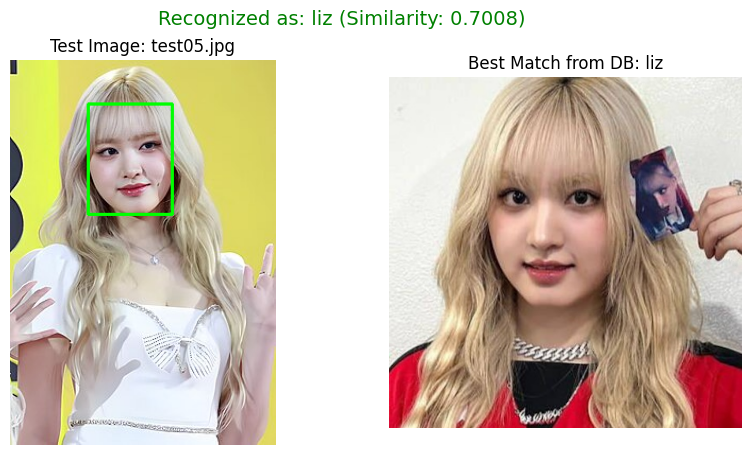


Processing test image: test02.jpg


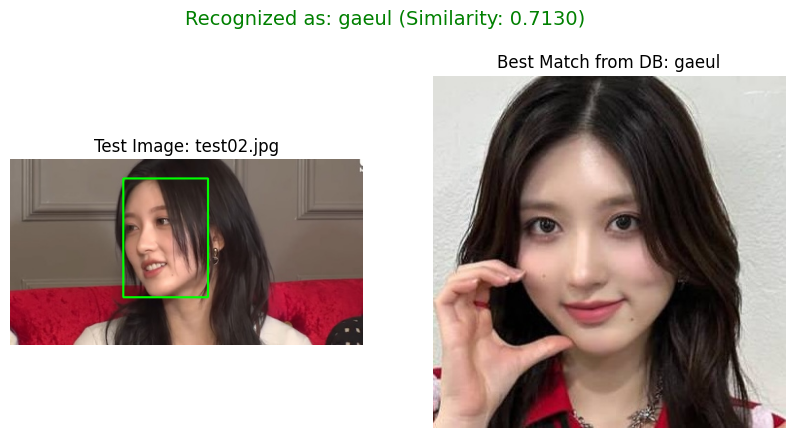


Processing test image: test03.jpg


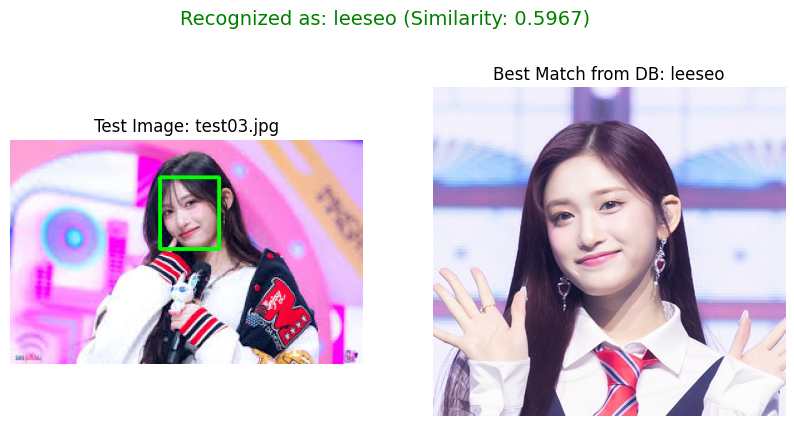


Processing test image: test06.jpg


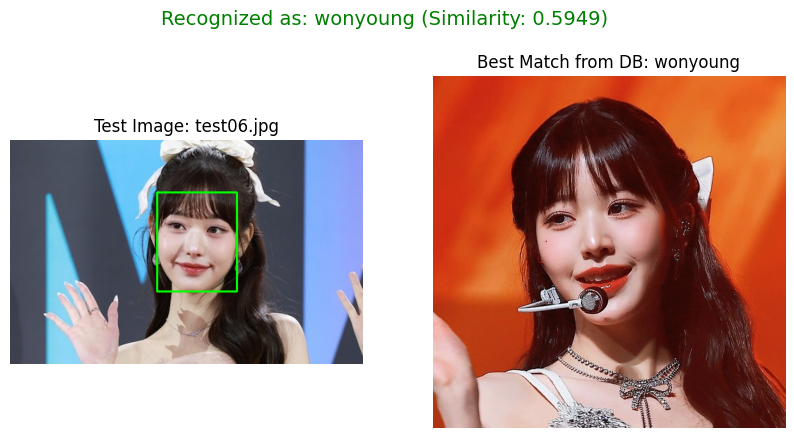


Processing test image: test04.jpg


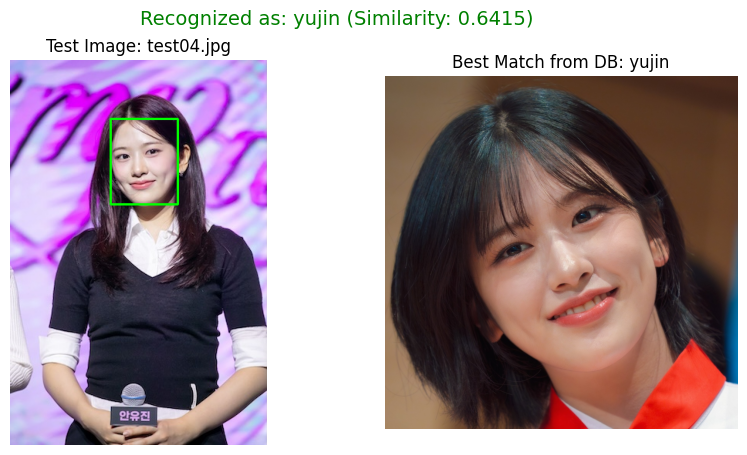


Processing test image: test01.jpg


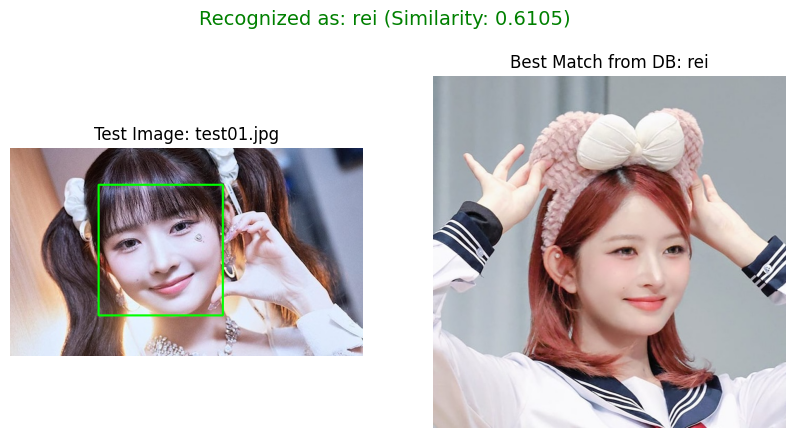


Recognition results saved to: /content/output_recognition_insightface/


In [48]:
# --- 測試 AI 辨識 IVE 成員 ---
test_photo_dir = '/content/test' # 請確保這是正確的路徑
output_dir = '/content/output_recognition_insightface/'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

if not representations:
    print("Cannot proceed with recognition as the database is empty.")
elif not os.path.exists(test_photo_dir):
    print(f"Error: Test photo directory not found: {test_photo_dir}")
else:
    test_images = glob.glob(os.path.join(test_photo_dir, '*.[jp][pn]g'))
    if not test_images:
        print(f"No test images found in {test_photo_dir}")

    for test_img_path in test_images:
        print(f"\nProcessing test image: {os.path.basename(test_img_path)}")
        try:
            test_img_cv = cv2.imread(test_img_path)
            if test_img_cv is None:
                print(f"  Warning: Could not read test image {test_img_path}")
                continue

            test_faces = app.get(test_img_cv)

            if len(test_faces) == 0:
                print(f"  No face detected in test image: {test_img_path}")
                # 儲存未偵測到人臉的圖片
                plt.imshow(cv2.cvtColor(test_img_cv, cv2.COLOR_BGR2RGB))
                plt.title(f"No Face Detected\n{os.path.basename(test_img_path)}")
                plt.axis('off')
                no_face_output_path = os.path.join(output_dir, f"no_face_{os.path.basename(test_img_path)}")
                plt.savefig(no_face_output_path)
                plt.show()
                display(HTML(f"<p style='color:red;'>No face detected in {os.path.basename(test_img_path)}</p>"))
                continue

            # 假設測試圖片中我們也只關心主要人臉 (通常是最大的或第一個)
            test_embedding = test_faces[0].embedding
            # test_embedding = test_embedding / np.linalg.norm(test_embedding) # 確保正規化

            best_match_name = "Unknown"
            highest_similarity = -1 # 餘弦相似度，越高越好
            best_match_path = None

            for rep in representations:
                db_embedding = rep['embedding']
                # db_embedding = db_embedding / np.linalg.norm(db_embedding) # 確保正規化

                # 計算餘弦相似度
                # reshape(1, -1) 是因為 cosine_similarity 期望二維陣列
                similarity = cosine_similarity(test_embedding.reshape(1, -1), db_embedding.reshape(1, -1))[0][0]

                if similarity > highest_similarity:
                    highest_similarity = similarity
                    best_match_name = rep['name']
                    best_match_path = rep['path']

            # 設定一個閾值 (例如 0.4 或 0.5，需要根據實驗調整)
            # ArcFace 的餘弦相似度通常比較高，對於同一個人，可能在 0.5 到 0.8+
            # 不同人之間可能在 0.0 到 0.4
            similarity_threshold = 0.4 # 這個閾值很重要，需要調整

            if highest_similarity >= similarity_threshold:
                recognition_result = f"Recognized as: {best_match_name} (Similarity: {highest_similarity:.4f})"
                result_color = "green"
            else:
                recognition_result = f"Unknown (Best match: {best_match_name}, Sim: {highest_similarity:.4f} < Threshold)"
                best_match_name = "Unknown" # 如果低於閾值，則標記為未知
                result_color = "orange"


            # 視覺化結果
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # 顯示測試圖片和偵測框
            display_test_img = test_img_cv.copy()
            bbox = test_faces[0].bbox.astype(int) # 偵測到的人臉邊界框
            cv2.rectangle(display_test_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
            axes[0].imshow(cv2.cvtColor(display_test_img, cv2.COLOR_BGR2RGB))
            axes[0].set_title(f"Test Image: {os.path.basename(test_img_path)}")
            axes[0].axis('off')

            # 顯示最佳匹配的資料庫圖片
            if best_match_path and best_match_name != "Unknown":
                match_img_cv = cv2.imread(best_match_path)
                axes[1].imshow(cv2.cvtColor(match_img_cv, cv2.COLOR_BGR2RGB))
                axes[1].set_title(f"Best Match from DB: {best_match_name}")
            else:
                axes[1].text(0.5, 0.5, 'No confident match found', ha='center', va='center')
                axes[1].set_title("No Confident Match")
            axes[1].axis('off')

            plt.suptitle(recognition_result, color=result_color, fontsize=14)
            output_img_path = os.path.join(output_dir, f"recognized_{os.path.basename(test_img_path)}")
            plt.savefig(output_img_path)
            plt.show()
            display(HTML(f"<p style='color:{result_color};'>{recognition_result}</p>"))

        except Exception as e:
            print(f"  Error processing test image {test_img_path}: {e}")

print(f"\nRecognition results saved to: {output_dir}")

### 5. 設定考試題目

In [23]:
# prompt: n = len(members)
# i = 0, 1, .., n-1
# 建立 QUESTION_IMAGE_SOURCES 字典格式:
# key 為 name_zh[i]
# value 為一個 list, 是所有在 test_photos 資料夾下, members[i] 這個資料夾下的所有檔案

n = len(members)

QUESTION_IMAGE_SOURCES = {}
for i in range(n):
    member_en_name = members[i]
    member_zh_name = name_zh[i]
    folder_path = f'/content/test_photos/{member_en_name}'
    if os.path.exists(folder_path):
        # glob.glob 返回符合模式的所有檔案路徑列表
        # os.path.join 可以正確組合路徑，確保跨平台相容性
        image_files = glob.glob(os.path.join(folder_path, '*.[jp][pn]g')) # 匹配 .jpg, .jpeg, .png
        QUESTION_IMAGE_SOURCES[member_zh_name] = image_files
        print(f"Found {len(image_files)} images for {member_zh_name} in {folder_path}")
    else:
        print(f"Warning: Folder not found for {member_zh_name} at {folder_path}")
        QUESTION_IMAGE_SOURCES[member_zh_name] = [] # 如果資料夾不存在，給一個空列表

print("\nQUESTION_IMAGE_SOURCES dictionary created:")
for key, value in QUESTION_IMAGE_SOURCES.items():
    print(f"{key}: {len(value)} images")
    # print(f"{key}: {value}") # 如果想看具體檔案列表可以取消註解這行

Found 1 images for 兪真유진 in /content/test_photos/yujin
Found 1 images for 員瑛원영 in /content/test_photos/wonyoung
Found 1 images for 秋天가을 in /content/test_photos/gaeul
Found 1 images for Liz리즈 in /content/test_photos/rei
Found 1 images for Rei레이 in /content/test_photos/liz
Found 1 images for 李瑞이서 in /content/test_photos/leeseo

QUESTION_IMAGE_SOURCES dictionary created:
兪真유진: 1 images
員瑛원영: 1 images
秋天가을: 1 images
Liz리즈: 1 images
Rei레이: 1 images
李瑞이서: 1 images


In [24]:
QUESTION_IMAGE_SOURCES

{'兪真유진': ['/content/test_photos/yujin/test04.jpg'],
 '員瑛원영': ['/content/test_photos/wonyoung/test01.jpg'],
 '秋天가을': ['/content/test_photos/gaeul/test03.jpg'],
 'Liz리즈': ['/content/test_photos/rei/test06.jpg'],
 'Rei레이': ['/content/test_photos/liz/test05.jpg'],
 '李瑞이서': ['/content/test_photos/leeseo/test02.jpg']}

### 6. 遊戲設定

In [53]:
# --- 遊戲設定 ---
# 假設 name_zh 和 QUESTION_IMAGE_SOURCES 已在之前的儲存格中定義

# 為了讓此儲存格能獨立測試（如果需要），可以取消註解並填入實際值
if 'name_zh' not in globals():
    print("警告：'name_zh' 未定義。將使用預設成員列表。")
    name_zh = ['兪真유진', '員瑛원영', '秋天가을', 'Liz리즈', 'Rei레이', '李瑞이서']

if 'members' not in globals(): # 'members' 是使用者提供的變數名
    print("警告：'members' (英文小寫列表) 未定義。將使用預設列表。")
    members = ['yujin', 'wonyoung', 'gaeul', 'liz', 'rei', 'leeseo']


if 'QUESTION_IMAGE_SOURCES' not in globals():
    print("警告：'QUESTION_IMAGE_SOURCES' 未定義。將使用預設的 placeholder 圖片路徑。")
    os.makedirs("/content/placeholder_images", exist_ok=True)
    placeholder_img_path = "/content/placeholder_images/default.png"
    try:
        if not os.path.exists(placeholder_img_path):
            ph_img = np.zeros((100,100,3), dtype=np.uint8)
            cv2.putText(ph_img, "Error", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.imwrite(placeholder_img_path, ph_img)
    except Exception as e:
        print(f"創建 placeholder 圖片失敗: {e}")
    QUESTION_IMAGE_SOURCES = { member_zh_name: [placeholder_img_path] for member_zh_name in name_zh }


IVE_MEMBERS = name_zh
SIMILARITY_THRESHOLD = 0.35

AI_NAME_TO_DISPLAY_NAME_MAP = {}
if len(members) == len(name_zh):
    AI_NAME_TO_DISPLAY_NAME_MAP = dict(zip(members, name_zh))
    print(f"自動產生的 AI_NAME_TO_DISPLAY_NAME_MAP: {AI_NAME_TO_DISPLAY_NAME_MAP}")
else:
    print("警告：英文成員列表 (members) 和中文成員列表 (name_zh) 長度不一致，無法自動生成 AI_NAME_TO_DISPLAY_NAME_MAP。AI辨識的名稱可能無法正確轉換！請手動配置或檢查列表。")
    AI_NAME_TO_DISPLAY_NAME_MAP = {
        'yujin': '兪真유진', 'wonyoung': '員瑛원영', 'gaeul': '秋天가을',
        'liz': 'Liz리즈', 'rei': 'Rei레이', 'leeseo': '李瑞이서'
    }

自動產生的 AI_NAME_TO_DISPLAY_NAME_MAP: {'yujin': '兪真유진', 'wonyoung': '員瑛원영', 'gaeul': '秋天가을', 'rei': 'Liz리즈', 'liz': 'Rei레이', 'leeseo': '李瑞이서'}


### 7. 因為 `Gemini` 一直沒抓到錯一改再改

In [54]:
# --- Gradio 儲存格啟動時的狀態檢查 ---
# Define DummyApp class in a place where it's always available if needed
class DummyApp: # Defined globally within this cell's script context
    def get(self, img):
        print("警告: DummyApp.get() 被呼叫，表示真實 AI 模型 'app' 未載入或無效。")
        return []

print("\n--- Gradio 儲存格啟動時的 AI 狀態檢查 ---")
# 檢查全域變數 'app' (InsightFace 模型)
if 'app' in globals() and app is not None and hasattr(app, 'get') and not isinstance(app, DummyApp):
    print(f"偵錯 (啟動時)：Colab 中的 'app' (AI 模型) 已定義且有效，類型為: {type(app)}。將使用此模型。")
    # app 變數將直接被後續函數作為全域變數使用
else:
    if 'app' not in globals():
        print("偵錯 (啟動時)：AI 模型 'app' 未在全域變數中定義。將使用 DummyApp。")
    elif app is None:
        print("偵錯 (啟動時)：AI 模型 'app' 為 None。將使用 DummyApp。")
    else:
        print(f"偵錯 (啟動時)：AI 模型 'app' (類型: {type(app)}) 不是預期的 FaceAnalysis 模型。將使用 DummyApp。")
    app = DummyApp() # 如果 'app' 無效或未定義，則將全域 'app' 覆蓋為 DummyApp 實例

# 檢查全域變數 'representations' (AI 參考資料庫)
if 'representations' in globals() and representations is not None:
    print(f"偵錯 (啟動時)：'representations' 已定義，包含 {len(representations)} 個項目。")
    if representations:
        print(f"偵錯 (啟動時)：'representations' 的第一個項目名稱: {representations[0].get('name', 'N/A')}")
else:
    print("偵錯 (啟動時)：'representations' 未定義、為 None 或為空。")
    representations = [] # 如果未定義或為 None，確保它至少是個空列表

print("--- AI 狀態檢查結束 ---\n")


# 後續的 try-except 塊用於名稱一致性檢查，不再重新檢查 app 和 representations 的存在性
try:
    if isinstance(app, DummyApp) or not representations:
        print("PK 賽的 AI 功能可能因模型或資料庫問題而受限 (基於啟動時檢查)。")
    else:
        print(f"PK 賽準備就緒，使用已載入的 InsightFace 模型和 {len(representations)} 個參考特徵。")

    print("\n--- 名稱一致性檢查 (再次確認) ---")
    print(f"1. 遊戲中使用的成員列表 (IVE_MEMBERS / name_zh): {IVE_MEMBERS}")
    if representations:
        rep_names = sorted(list(set([item['name'] for item in representations])))
        print(f"2. AI 參考資料庫 (representations) 中的原始名稱 (應為小寫英文): {rep_names}")
    else:
        print("2. AI 參考資料庫 (representations) 為空。")
    print(f"3. AI 名稱映射字典的鍵 (AI_NAME_TO_DISPLAY_NAME_MAP.keys()) (應為小寫英文): {sorted(list(AI_NAME_TO_DISPLAY_NAME_MAP.keys()))}")
    print("請確保上述『AI 參考資料庫中的原始名稱』都能在『AI 名稱映射字典的鍵』中找到 (且大小寫一致)，")
    print("並且映射字典的值與『遊戲中使用的成員列表』中的名稱格式一致。")
    print("--- 名稱一致性檢查結束 ---\n")

except Exception as e:
    print(f"Gradio 儲存格名稱一致性檢查時發生預期外的錯誤: {e}")
    if 'app' not in globals() or app is None : app = DummyApp() # 確保 app 存在
    if 'representations' not in globals(): representations = []


def ai_recognize_face(image_cv):
    """使用 AI 模型辨識圖片中的人臉 (image_cv 應為 OpenCV 格式的圖片)"""
    # 使用全域變數 app, representations, AI_NAME_TO_DISPLAY_NAME_MAP
    global app, representations, AI_NAME_TO_DISPLAY_NAME_MAP

    if isinstance(app, DummyApp) or app is None: # 直接檢查 app
        return "AI 模型未正確初始化", 0.0
    if not representations:
        return "AI 參考資料庫 (representations) 為空", 0.0

    try:
        faces = app.get(image_cv) # 使用 app
        if not faces or len(faces) == 0:
            return "AI 未在此圖片中偵測到人臉", 0.0

        test_embedding = faces[0].embedding

        best_match_name_from_ai_db = "未知成員"
        highest_similarity = -1.0

        for ref in representations:
            if 'name' not in ref or 'embedding' not in ref:
                print(f"警告：representations 中的項目格式不正確: {ref}。跳過。")
                continue
            if not isinstance(ref["embedding"], np.ndarray):
                print(f"警告：參考資料庫中 {ref['name']} 的 embedding 不是 numpy array。跳過。")
                continue
            similarity = cosine_similarity(test_embedding.reshape(1, -1), ref["embedding"].reshape(1, -1))[0][0]
            if similarity > highest_similarity:
                highest_similarity = similarity
                best_match_name_from_ai_db = ref["name"]

        final_best_match_name = AI_NAME_TO_DISPLAY_NAME_MAP.get(best_match_name_from_ai_db, best_match_name_from_ai_db)
        if best_match_name_from_ai_db != "未知成員" and final_best_match_name == best_match_name_from_ai_db and best_match_name_from_ai_db not in AI_NAME_TO_DISPLAY_NAME_MAP:
             print(f"警告：AI 辨識出的原始名稱 '{best_match_name_from_ai_db}' 未在 AI_NAME_TO_DISPLAY_NAME_MAP 中找到映射，將直接使用此原始名稱。請檢查映射是否需要更新。")

        if highest_similarity >= SIMILARITY_THRESHOLD:
            return final_best_match_name, highest_similarity
        else:
            return f"未知 (最接近: {final_best_match_name} 但相似度 {highest_similarity:.2f} < {SIMILARITY_THRESHOLD})", highest_similarity
    except Exception as e:
        print(f"AI 辨識過程中發生錯誤: {e}")
        return "AI 辨識時發生內部錯誤", 0.0


--- Gradio 儲存格啟動時的 AI 狀態檢查 ---
偵錯 (啟動時)：Colab 中的 'app' (AI 模型) 已定義且有效，類型為: <class 'insightface.app.face_analysis.FaceAnalysis'>。將使用此模型。
偵錯 (啟動時)：'representations' 已定義，包含 41 個項目。
偵錯 (啟動時)：'representations' 的第一個項目名稱: wonyoung
--- AI 狀態檢查結束 ---

PK 賽準備就緒，使用已載入的 InsightFace 模型和 41 個參考特徵。

--- 名稱一致性檢查 (再次確認) ---
1. 遊戲中使用的成員列表 (IVE_MEMBERS / name_zh): ['兪真유진', '員瑛원영', '秋天가을', 'Liz리즈', 'Rei레이', '李瑞이서']
2. AI 參考資料庫 (representations) 中的原始名稱 (應為小寫英文): ['gaeul', 'leeseo', 'liz', 'rei', 'wonyoung', 'yujin']
3. AI 名稱映射字典的鍵 (AI_NAME_TO_DISPLAY_NAME_MAP.keys()) (應為小寫英文): ['gaeul', 'leeseo', 'liz', 'rei', 'wonyoung', 'yujin']
請確保上述『AI 參考資料庫中的原始名稱』都能在『AI 名稱映射字典的鍵』中找到 (且大小寫一致)，
並且映射字典的值與『遊戲中使用的成員列表』中的名稱格式一致。
--- 名稱一致性檢查結束 ---



### 8. Gradio 應用程式的邏輯函式

In [55]:
def start_new_round_internal():
    """內部函式：準備新一局的題目"""
    member_name = random.choice(IVE_MEMBERS)

    if member_name not in QUESTION_IMAGE_SOURCES or not QUESTION_IMAGE_SOURCES[member_name]:
        error_img_path = "/content/placeholder_images/error_no_image.png"
        if not os.path.exists(error_img_path):
             os.makedirs("/content/placeholder_images", exist_ok=True)
             ph_img = np.zeros((100,100,3), dtype=np.uint8); cv2.putText(ph_img, "NoImg", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2); cv2.imwrite(error_img_path, ph_img)
        print(f"警告：成員 {member_name} 在 QUESTION_IMAGE_SOURCES 中沒有有效的圖片路徑。")
        return {"member_name": member_name, "image_path": error_img_path}, error_img_path

    image_path = random.choice(QUESTION_IMAGE_SOURCES[member_name])

    if not os.path.exists(image_path):
        print(f"警告：題目圖片檔案 {image_path} 不存在。將使用預設錯誤圖片。")
        error_img_path = "/content/placeholder_images/error_file_not_found.png"
        if not os.path.exists(error_img_path):
             os.makedirs("/content/placeholder_images", exist_ok=True)
             ph_img = np.zeros((100,100,3), dtype=np.uint8); cv2.putText(ph_img, "NoFile", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2); cv2.imwrite(error_img_path, ph_img)
        return {"member_name": member_name, "image_path": error_img_path}, error_img_path

    current_question = {"member_name": member_name, "image_path": image_path}
    return current_question, image_path


def start_new_round_gradio(current_scores_state):
    """Gradio 的「開始新遊戲/下一題」按鈕觸發函式"""
    current_question_data, image_path_to_display = start_new_round_internal()

    ai_guess_display_text = ""
    user_result_display_text = ""
    ai_result_display_text = ""
    correct_answer_display_text = ""

    return (
        image_path_to_display,
        ai_guess_display_text,
        user_result_display_text,
        ai_result_display_text,
        correct_answer_display_text,
        current_question_data,
        current_scores_state
    )


def submit_guess_gradio(user_choice, current_question_state, current_scores_state):
    """Gradio 的「猜！」按鈕觸發函式"""
    global app # 確保 submit 函數能存取到啟動時設定的 (可能是 DummyApp 的) app

    if not current_question_state or 'image_path' not in current_question_state or not current_question_state['image_path']:
        error_message = "錯誤：請先點擊「開始新遊戲」按鈕。"
        score_display_text = f"你的分數: {current_scores_state['user']} - AI 的分數: {current_scores_state['ai']}"
        return error_message, error_message, error_message, error_message, score_display_text, current_scores_state, current_question_state

    true_member_name = current_question_state["member_name"]
    image_path = current_question_state["image_path"]

    ai_guess_name_raw = "AI 無法處理圖片"
    ai_similarity = 0.0

    ai_ready = True
    print("\n--- 執行 submit_guess_gradio 時的 AI 狀態檢查 (再次確認) ---")
    # 直接檢查全域 'app' 變數的狀態
    if 'app' not in globals(): # 雖然啟動時會創建 DummyApp，但以防萬一
        print("偵錯 (submit)：AI 模型 'app' 不在全域變數中。")
        ai_ready = False
    elif app is None:
        print("偵錯 (submit)：AI 模型 'app' 為 None。")
        ai_ready = False
    elif isinstance(app, DummyApp):
        print("偵錯 (submit)：AI 模型 'app' 是一個 DummyApp 物件。")
        ai_ready = False
    else:
        print("偵錯 (submit)：AI 模型 'app' 看起來已定義且非 DummyApp。")

    if 'representations' not in globals():
        print("偵錯 (submit)：'representations' 不在全域變數中。")
        ai_ready = False
    elif representations is None:
        print("偵錯 (submit)：'representations' 為 None。")
        ai_ready = False
    elif not representations:
        print("偵錯 (submit)：'representations' 列表為空。")
        ai_ready = False
    elif representations:
         print(f"偵錯 (submit)：'representations' 包含 {len(representations)} 個項目。第一個項目名稱: {representations[0].get('name', 'N/A') if representations else 'N/A'}")
    print("--- AI 狀態檢查結束 ---")

    if not ai_ready:
        ai_guess_name_raw = "AI 模型或資料庫未準備好 (詳見 Colab 控制台輸出)"
    elif os.path.exists(image_path):
        question_image_cv = cv2.imread(image_path)
        if question_image_cv is not None:
            ai_guess_name_raw, ai_similarity = ai_recognize_face(question_image_cv)
        else:
            ai_guess_name_raw = f"AI 無法從路徑讀取圖片 ({os.path.basename(image_path)})"
    else:
        ai_guess_name_raw = f"AI 錯誤：題目圖片檔案不存在 ({os.path.basename(image_path)})"


    user_correct = (user_choice == true_member_name)
    ai_correct = (ai_guess_name_raw == true_member_name)

    user_result_str = f"【你的答案：{user_choice}】恭喜你，猜對了！🎉" if user_correct else f"【你的答案：{user_choice}】可惜，你猜錯了！😢"
    ai_result_str = f"【AI 的答案：{ai_guess_name_raw}】AI 也猜對了！🤖👍" if ai_correct else f"【AI 的答案：{ai_guess_name_raw}】AI 也猜錯了！🤖👎"

    correct_answer_str = f"本題正確答案是：{true_member_name}"
    ai_full_guess_str = f"{ai_guess_name_raw}"
    if not any(err_msg in ai_guess_name_raw for err_msg in ["未偵測到", "錯誤", "未初始化", "資料庫為空", "無法處理", "無法讀取", "不存在", "未準備好", "未知 (最接近:"]):
         ai_full_guess_str += f" (相似度: {ai_similarity:.3f})"
    elif "未知 (最接近:" in ai_guess_name_raw:
        pass

    updated_scores = dict(current_scores_state)
    if user_correct:
        updated_scores["user"] += 1
    if ai_correct:
        updated_scores["ai"] += 1

    score_display_text = f"你的分數: {updated_scores['user']}  |  AI 的分數: {updated_scores['ai']}"

    return (
        ai_full_guess_str,
        user_result_display,
        ai_result_display,
        correct_answer_str,
        score_display_text,
        updated_scores,
        current_question_state
    )

### 9. Gradio 介面定義

In [ ]:
default_display_image_path = "/content/placeholder_images/initial.png"
if not os.path.exists(default_display_image_path):
    os.makedirs("/content/placeholder_images", exist_ok=True)
    ph_img = np.zeros((300,400,3), dtype=np.uint8); cv2.putText(ph_img, "Click Start", (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3); cv2.imwrite(default_display_image_path, ph_img)

initial_question_state_val = {"member_name": "", "image_path": default_display_image_path}
initial_scores_state_val = {"user": 0, "ai": 0}

with gr.Blocks(title="IVE 成員 PK 賽 (Colab - 本地圖片)", theme=gr.themes.Soft(primary_hue=gr.themes.colors.pink, secondary_hue=gr.themes.colors.purple)) as demo:
    gr.Markdown(
        """
        # 🎶 IVE 成員 PK 賽 (Colab 版 - 本地題目) 🎤
        看看你和 AI 誰才是真正的 DIVE！題目圖片從 Colab 本地檔案系統載入。
        ---
        **遊戲玩法：**
        1.  點擊「開始新遊戲 / 下一題」按鈕，系統會隨機顯示一位 IVE 成員的照片。
        2.  從下拉選單中選擇你認為照片中的成員是誰。
        3.  點擊「猜！」按鈕提交你的答案。
        4.  系統會同時顯示 AI 的辨識結果，並公佈正確答案和雙方的得分。
        ---
        **重要提示：**
        -   請確保本儲存格執行前，已在**之前的儲存格**成功載入 AI 模型 (在 Colab 中命名為 `app`)、`representations` (AI 參考臉部特徵資料庫)、`name_zh` (成員中文名稱列表)、`members` (成員小寫英文名稱列表) 和 `QUESTION_IMAGE_SOURCES` (包含本地圖片路徑的字典)。
        -   AI 辨識所用的參考名稱 (小寫英文) 會透過 `AI_NAME_TO_DISPLAY_NAME_MAP` 映射到 `name_zh` 中的標準名稱 (中文)，以確保一致性。**此映射現在是根據 `members` 和 `name_zh` 列表自動產生的。**
        -   如果 AI 相關變數或圖片路徑未正確設定，遊戲可能無法正常運作。**如果 AI 持續顯示「未準備好」，請檢查 Colab 控制台的輸出以獲取詳細的偵錯訊息。** (啟動時也會有名稱一致性檢查的輸出)
        """
    )

    current_question_gr_state = gr.State(value=initial_question_state_val)
    current_scores_gr_state = gr.State(value=initial_scores_state_val)

    with gr.Row():
        with gr.Column(scale=2):
            question_image_display = gr.Image(
                label="📸 題目照片",
                value=initial_question_state_val["image_path"],
                height=400,
                interactive=False,
                show_download_button=False
            )
            start_button = gr.Button("🚀 開始新遊戲 / 下一題", variant="secondary", scale=1)

        with gr.Column(scale=3):
            user_input_dropdown = gr.Dropdown(
                choices=IVE_MEMBERS,
                label="👤 請選擇你認為是哪位成員："
            )
            submit_button = gr.Button("💡 猜！", variant="primary")

            gr.Markdown("--- 🔍 結果揭曉 ---")
            correct_answer_display = gr.Textbox(label="👑 正確答案是：", interactive=False)
            user_result_display = gr.Textbox(label="🧑‍🎓 你的作答結果：", interactive=False)
            ai_guess_display = gr.Textbox(label="🤖 AI 的辨識結果：", interactive=False)
            ai_result_display = gr.Textbox(label="🧠 AI 的作答結果：", interactive=False)

            score_label = gr.Label(
                f"🏆 目前比分 -> 你的分數: {initial_scores_state_val['user']}  |  AI 的分數: {initial_scores_state_val['ai']}"
            )

    start_button.click(
        fn=start_new_round_gradio,
        inputs=[current_scores_gr_state],
        outputs=[
            question_image_display,
            ai_guess_display,
            user_result_display,
            ai_result_display,
            correct_answer_display,
            current_question_gr_state,
            current_scores_gr_state
        ]
    )

    submit_button.click(
        fn=submit_guess_gradio,
        inputs=[user_input_dropdown, current_question_gr_state, current_scores_gr_state],
        outputs=[
            ai_guess_display,
            user_result_display,
            ai_result_display,
            correct_answer_display,
            score_label,
            current_scores_gr_state,
            current_question_gr_state
        ]
    )

In [56]:
# 在 Colab 中啟動 Gradio 應用程式
print("正在啟動 Gradio 應用程式 (本地圖片題目版 - 名稱已同步)...")
demo.launch(debug=True, share=True)

正在啟動 Gradio 應用程式 (本地圖片題目版 - 名稱已同步)...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://59bf725af0bc549831.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



--- 執行 submit_guess_gradio 時的 AI 狀態檢查 (再次確認) ---
偵錯 (submit)：AI 模型 'app' 看起來已定義且非 DummyApp。
偵錯 (submit)：'representations' 包含 41 個項目。第一個項目名稱: wonyoung
--- AI 狀態檢查結束 ---

--- 執行 submit_guess_gradio 時的 AI 狀態檢查 (再次確認) ---
偵錯 (submit)：AI 模型 'app' 看起來已定義且非 DummyApp。
偵錯 (submit)：'representations' 包含 41 個項目。第一個項目名稱: wonyoung
--- AI 狀態檢查結束 ---

--- 執行 submit_guess_gradio 時的 AI 狀態檢查 (再次確認) ---
偵錯 (submit)：AI 模型 'app' 看起來已定義且非 DummyApp。
偵錯 (submit)：'representations' 包含 41 個項目。第一個項目名稱: wonyoung
--- AI 狀態檢查結束 ---

--- 執行 submit_guess_gradio 時的 AI 狀態檢查 (再次確認) ---
偵錯 (submit)：AI 模型 'app' 看起來已定義且非 DummyApp。
偵錯 (submit)：'representations' 包含 41 個項目。第一個項目名稱: wonyoung
--- AI 狀態檢查結束 ---
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://59bf725af0bc549831.gradio.live
